# Coursework 3

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Stochastic Differential Equations - Ornstein-Ühlenbeck problem

Consider the Ornstein-Uhlenbeck problem
$$
  \text{d}X = -\lambda X \, \text{d}t + \mu \, \text{d}W.
$$

Its solution is
$$
  X(t) = e^{-\lambda t} X_0 + \mu \int_0^t e^{-\lambda (t - s)} \, \text{d}W(s).
$$

In addition, we can calculate $\mathbb{E}(X)$ and $\mathbb{E}(X^2)$ as
$$
\begin{align}
  \mathbb{E}(X) & = e^{-\lambda t} X_0, \\
  \mathbb{E}(X^2) & = e^{-2\lambda t} X_0^2 + \frac{\mu^2}{2 \lambda} \left( 1 - e^{-2 \lambda t} \right).
\end{align}
$$
In particular we can show that
$$
  \lim_{t \to \infty} X \sim N \left( 0, \frac{\mu^2}{2 \lambda} \right):
$$
that is, for late enough time the solution follows a normal distribution.

### Tasks

1. Solve the Ornstein-Ühlenbeck problem using the Euler-Maruyama method. Use $X_0 = 1, \lambda=1, \mu=1$ and solve to end time $T=1$. Using $\delta t = 2^{- \left(4, \dots, 10\right)}$ check the weak order of convergence by looking at the error in $X^2$.
2. Plot a histogram of $X(10)$ for $10^5$ realizations with $\delta t = 2^{-7}$, using Euler-Maruyama. How is it distributed?
3. By computing the mean of $X^2(T)$ (which is the variance), check that 
$$
  X^{(h)}(T) \sim N \left( 0, \frac{\mu^2}{2 \lambda - \lambda^2 \, \delta t} \right)
$$
for $T=10$ (which is meant to represent "large" $T$).
4. Repeat these steps for the theta method
$$
  X_{n+1} = X_n - \lambda \, \delta t \, \theta X_{n+1} - \lambda \, \delta t \, (1 - \theta) X_n + \mu \, \text{d}W_n
$$
for $\theta=1/2$. Why is it different?

In [32]:
import pytest
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

In [33]:
def EM(dW, h, X0, f, g):
    """
    Compute the approximate solution X(t) of an SDE of the form,

        dX = fdt + gdW,

    using the Euler-Maruyama method.

    Parameters
    ----------
    dW: (1 x t) array of floats.
        The value of the random noise at each point t; this is not a cum sum
        unlike W.
    h: float.
        The grid spacing for t.
    X0: float.
        The initial value of the solution, given by X(0).
    f: function.
        A function to define the deterministic part of the SDE.
    g: function.
        A function to define the stochasic part of the SDE.

    Returns
    -------
    X_EM: (1 x t+1) array of floats.
        The approximate value of X(t) at each point t as given by the Euler-
        Maryuama method.
    """

    if h <= 0:  # h has to be positive
        raise ValueError('The grid spacing, h, can\'t be negative or zero.')

    # at least 2 increments are needed to evaulate the SDE
    assert(len(dW) > 1), 'Not enough Wiener increments to evaulate.'

    # check values are finite
    assert(np.isfinite(h)), 'h needs to be a finite number.'
    assert(np.isfinite(X0)), 'X0 needs to be a finite number.'

    # check that the function arguments are callable
    assert(callable(f)), 'The argument for f is not a callable function.'
    assert(callable(g)), 'The argument for g is not a callable function.'

    def EM_step(X, dW):
        """
        The stepping alogorithm for the Euler-Maruyama method. Takes in a value
        X(t) and returns X(t+1).

        Parameters
        ----------
        X: float.
            The value of X(t) at a given point, t.
        dW: float.
            The random noise dW at the point t.

        Returns
        -------
        Xn: float.
            The value of X(t+h).
        """

        fn = f(X)
        gn = g(X)

        Xn = X + fn * h + gn * dW

        # check that Xn is finite, otherwise the solver has blown up
        assert(np.isfinite(Xn))

        return Xn

    N = dW.shape[0]
    X_EM = np.zeros(N+1)
    X_EM[0] = X0

    for i in range(N):
        X_EM[i+1] = EM_step(X_EM[i], dW[i])

    # check that the initial value has not been overwritten
    assert(X_EM[0] == X0), 'Initial value has been lost.'

    return X_EM


def TM(dW, h, X0, theta, mu, lamda):
    """
    Compute the approximate solution X(t) of the Ornstein-Uhlenbeck equation,

        dX = - lambda * X * dt + mu * dW,

    using the Theta method.

    Parameters
    ----------
    dW: (1 x t) array of floats.
        The value of the random noise at each point t; this is not a cum sum
        unlike W.
    h: float.
        The grid spacing for t.
    X0: float.
        The initial value of the solution, given by X(0).
    theta: float.
        The value of the theta parameter. When theta = 0, the theta method
        reduces to the Euler-Maruyama method.
    lamda: float.
        The value of the lambda parameter, i.e. the value for the deterministic
        part of the OU equation.
    mu: function.
        The value of the mu parameter, i.e. the value for the stochastic
        part of the OU equation.

    Returns
    -------
    X_Theta: (1 x t+1) array of floats.
        The approximate value of X(t) at each point t as given by the theta
        method.
    """

    if h <= 0:  # h has to be positive
        raise ValueError('the grid spacing, h, can\'t be negative or zero')

    # at least 2 increments are needed to evaulate the SDE
    assert(len(dW) > 1), 'Not enough Wiener increments to evaulate.'

    # the parameter values have to be finite, otherwise things explode
    assert(np.isfinite(h)), 'h needs to be a finite number.'
    assert(np.isfinite(X0)), 'X0 needs to be a finite number.'
    assert(np.isfinite(theta)), 'theta needs to be a finite number.'
    assert(np.isfinite(mu)), 'mu needs to be a finite number.'
    assert(np.isfinite(lamda)), 'lamda needs to be a finite number.'

    def theta_step(X, dW):
        """
        The stepping alogorithm for the Euler-Maruyama method. Takes in a value
        X(t) and returns X(t+1).

        Parameters
        ----------
        X: float.
            The value of X(t) at a given point, t.
        dW: float.
            The random noise dW at the point t.

        Returns
        -------
        Xn: float.
            The value of X(t+h).
        """

        Xn = (X - lamda * h * (1 - theta) * X + mu * dW) / \
            (1 + lamda * h * theta)

        # check that Xn is finite, otherwise the solver has blown up
        assert(np.isfinite(Xn))

        return Xn

    N = dW.shape[0]
    X_Theta = np.zeros(N+1)
    X_Theta[0] = X0

    for i in range(N):
        X_Theta[i+1] = theta_step(X_Theta[i], dW[i])

    # check that the initial value has not been overwritten
    assert(X_Theta[0] == X0), 'Initial value has been lost.'

    return X_Theta


def OU_Expectation(X0, mu, lamda, t):
    """
    Computes the expectation and the square of the expectation value of
    the Ornstein-Uhlenbeck problem.

    Parameters
    ----------
    X0: float.
        The initial value of the solution, given by X(0).
    mu: float.
        The scaling parameter for the stochastic part of the O-U equation.
    lamda: float.
        The scaling parameter for the deterministic part of the O-U
        equation.
    t: (1 x t) array of floats.
        The values of t to evaulate the O-U expected values.

    Returns
    -------
    Ex: (1 x t) array of floats.
        The expectation value of the O-U equation at each value of t.
    ExSq: (1 x t) array of floats.
        The expectation value of the square value of the O-U equation at each
        value of t.
    """

    assert(t.shape[0] > 1), 'More than one grid space is needed to calculate \
        the expected values.'
    # make sure the values we are being given are finite
    assert(np.isfinite(X0))
    assert(np.isfinite(mu))
    assert(np.isfinite(lamda))

    Ex = np.exp(-lamda * t) * X0
    ExSq = np.exp(-2 * lamda * t) * X0 ** 2 + (mu ** 2)/(2 * lamda) * \
        (1 - np.exp(-2 * lamda * t))

    return Ex, ExSq

# Testing

In [45]:
def testing_funcs(msg=False):
    """
    Function containing all of the testing functions.
    
    Parameters
    ----------
    msg: bool.
        If True, the functions will print a message to show that the testing
        has been successful. If False, no message will be printed.
    """

    if msg is True:
        print('#### beginning tests ####\n')
    
    def test_EM(msg=False):
        """
        Testing the EM function.
        
        Parameters
        ----------
        msg: bool.
            If True, the functions will print a message to show that the testing
            has been successful. If False, no message will be printed.
        """

        # create some placeholder data
        dW = np.zeros(10)
        dt = 0.1
        X0 = 1
        fn = lambda x: 0
        gn = lambda x: 0

        with pytest.raises(AssertionError):
            # the EM function is more robust than the TM function as it can take in
            # functions for the deterministic and stochastic part of the equation. 
            # Thus test to make sure the function checks the fn and gn arguments are 
            # functions
            EM(dW, dt, X0, 0, gn)
            EM(dW, dt, X0, fn, 0)

            # test that the function returns errors when bad input is given
            EM([1], dt, X0, fn, gn)  # not enough wiener increments

        # test that an error is returned when bad input for h is given
        with pytest.raises(ValueError):
            EM(dW, 0, X0, fn, gn)
            EM(dW, -1, X0, fn, gn)

        # the first element of the solution returned should be X0 otherwise the 
        # initial value has been lost.
        X = EM(dW, dt, X0, fn, gn)
        assert(X[0] == X0)

        # feed in a simple case where gn returns zero, i.e. there is no 
        # stochastic noise. This results in the EM method reducing to the Euler
        # method of solving an initial value problem thus we can test the output
        X = EM(dW, 0.5, 1, lambda x: x, lambda x: 0)
        # sequence should go 1, 1.5, 2.25, .., 25.62, 38.44, 57.66.
        assert(X[0] == 1)
        assert(X[1] == 1.5)
        assert(np.isclose(X[-1], 57.6650391))
        assert(np.isclose(X[-2], 38.4433594))
        # X should be of size N+1
        assert(X.size == len(dW)+1)

        # same as above, but now gn is 1 and the dW increments will be 1 also, thus
        # the stochastic part will be adding an extra value
        dW = np.ones(10)
        X = EM(dW, 0.5, 1, lambda x: x, lambda x: 1)
        # sequence should go 1, 2.5, 4.75, ..., 74.88, 113.33, 170.00
        assert(X[0] == 1)
        assert(X[1] == 2.5)
        assert(np.isclose(X[-1], 170.9951172))
        assert(np.isclose(X[-2], 113.3300781))
        # X should be of size N+1
        assert(X.size == len(dW)+1)

        if msg is True:
            print('EM testing passed.')
            
        
    def test_TM(msg=False):
        """
        Test the TM fuction.
        
        Parameters
        ----------
        msg: bool.
            If True, the functions will print a message to show that the testing
            has been successful. If False, no message will be printed.
        """

        # create some placeholder data
        dW = np.zeros(10)
        dt = 0.1
        X0 = 1
        lamda = 1
        mu = 1
        theta = 0.5

        # check that the function returns an error when bad input is given for dW
        with pytest.raises(AssertionError):
            TM([1], dt, X0, theta, mu, lamda)

        # check that the function returns an error when bad values of h are used
        with pytest.raises(ValueError):
            TM(dW, 0, X0, theta, mu, lamda)
            TM(dW, -1, X0, theta, mu, lamda)

        # the first element of the solution returned should be X0
        X = TM(dW, dt, X0, theta, mu, lamda)
        assert(X[0] == X0)
        # X should be of size N+1
        assert(X.size == len(dW)+1)
        
        # test TM for some simple parameters, lamda = 1, mu = 0, theta = 0.5. The
        # sequence should go, 1, 0.6, 0.36, ..., 0.016, 0.01, 0.00604
        X = TM(dW, 0.5, 1, 0.5, 0, 1)
        assert(X[0] == 1)
        assert(X[1] == 0.6)
        assert(np.isclose(X[-1], 0.006046618))
        assert(np.isclose(X[-2], 0.010077696))
        
        # test TM now for when now mu = 1, dW = 1, the sequence should go,
        # 1, 1.4, 1.64, ..., 1.983, 1.989, 1.99
        dW = np.ones(10)
        X = TM(dW, 0.5, 1, 0.5, 1, 1)
        assert(X[0] == 1)
        assert(X[1] == 1.4)
        assert(np.isclose(X[-1], 1.993953382))
        assert(np.isclose(X[-2], 1.989922304))

        if msg is True:
            print('TM testing passed.')

            
    test_EM(msg)
    test_TM(msg)
    
    if msg is True:
        print('\n#### testing passed ####')
    
msg=True 
testing_funcs(msg)

#### beginning tests ####

EM testing passed.
TM testing passed.

#### testing passed ####


# Functions/Constants for Solvers

In [34]:
def fn(x):
    """
    A function to define the deterministic part of the O-U equation.

    Parameters
    ----------
    x: float.
        A grid location x.

    Returns
    -------
    The value of the deterministic coefficent at the point x.
    """

    lamda = 1
    return - lamda * x


def gn(x):
    """
    A function to define the stochastic part of the O-U equation.

    Parameters
    ----------
    x: float.
        A grid location x.

    Returns
    -------
    The value of the stochastic coefficent at the point x.
    """

    mu = 1
    return mu


X0 = 1          # the starting value for the O-U equation
lamda = 1       # the parameter for the deterministic part of the O-U equation
mu = 1          # the parameter for the stochastic part of the O-U equation

# Weak Convergence of the Euler-Maruyama Method
    

In [4]:
# the weak convergence of the method is being tested using time steps,
# dt = 2 ** -(4, 5, .. 11). Thus 7 resolutions will be used with the number of
# paths being (16) up to (1024) paths.

t_start = 0                      # starting value to solve
t_end = 1                        # end value to solve to
N = 2 ** 10                      # refernce number of Wiener increments
M = 10 ** 5                      # reference number of realisations
n_resolutions = 7                # the number of resolutions to use
resolutions = 2 ** np.arange(n_resolutions)
t, dt = np.linspace(t_start, t_end, N+1, retstep=True)  # reference t, dt vals

# as the weak convergence subtracts the expected values as the error, we can
# used the expected solution rather than solving the stochastic integral
EX, EXSq = OU_Expectation(X0, mu, lamda, t)  # calc expected values

dT = np.zeros(n_resolutions)
weak_errors = np.zeros(n_resolutions)
for i, r in enumerate(resolutions):
    dT[i] = dt_r = r * dt  # calculate grid spacing for N points on grid
    t_r = t[::r]           # use ref grid to get grid points location
    dW = np.sqrt(dt_r) * np.random.randn(N//r, M)

    # calculate solution for each realisation
    X_EM_W = np.zeros((len(t_r), M))
    for m in range(M):
        X_EM_W[:, m] = EM(dW[:, m], dt_r, X0, fn, gn)

    # compute average path over all the realisations and compute the
    # errors in X ** 2, as the values will always be positive
    weak_errors[i] = np.abs(np.mean(np.square(X_EM_W[-1, :])) - EXSq[-1])

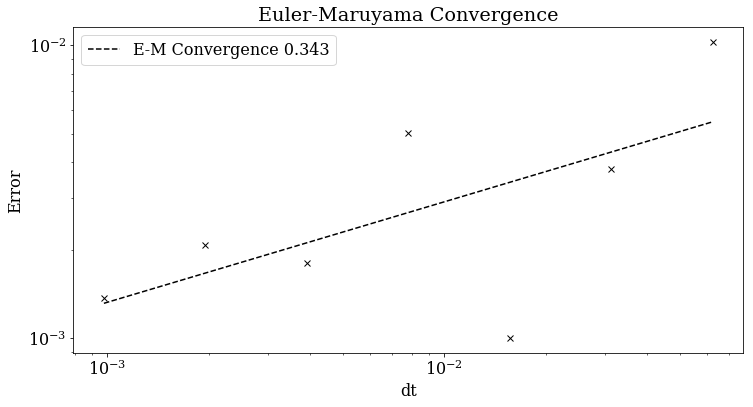

In [5]:
# fit linear line to data to find convergence
weak_fit = np.polyfit(np.log(dT), np.log(weak_errors), 1)

plt.loglog(dT, weak_errors, 'kx')
plt.loglog(dT, np.exp(weak_fit[1]) * dT ** weak_fit[0],
           'k--', label='E-M Convergence {:2.3f}'.format(weak_fit[0]))
plt.xlabel('dt')
plt.ylabel('Error')
plt.legend()
plt.title('Euler-Maruyama Convergence')
plt.show()

For Euler-Maruyama we are expecting linear convergence. Linear convergence is expected due to the deterministic part of the equation being evaulated using the Euler method which has linear convergence. Due to this linear convergence, the random noise introduced by the Wiener increments does not dominate the error of the Euler-Maruyama method.

However, the converenge plot above is messy, and is not obvioulsy linear convergence. We can expect the weak convergence of the Euler-Maruyama to converge towards 1 as the number of realisations, M, increases. This is because as we average over more realisations, the average of the path will be closer to 0 as more paths cancel out. Thus the error associated with the solving method will be due to the error associated with solving the deterministic part.

# Euler-Maruyama Histogram

In [16]:
t_start = 0
t_end = 10
N = 1280                    # using this will return dt = 2 ** -7
M = 10 ** 5
t_end = 10
t, dt = np.linspace(t_start, t_end, N+1, retstep=True)
dW = np.sqrt(dt) * np.random.randn(N, M)

X_EM_H = np.zeros((N+1, M))
for m in range(M):
    X_EM_H[:, m] = EM(dW[:, m], dt, X0, fn, gn)

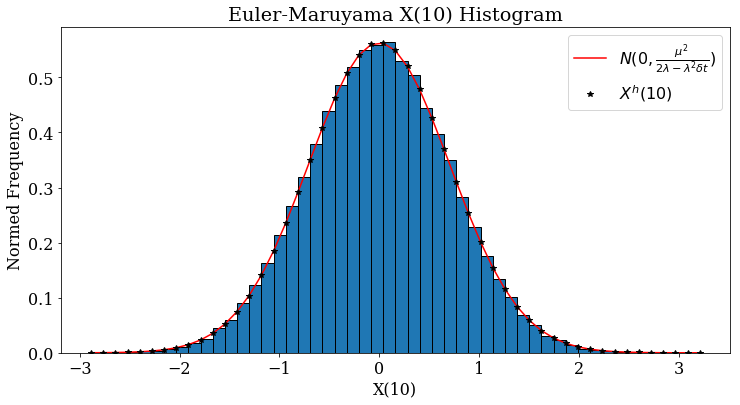

Reference variance: 0.502
Reference mean: 0.000
E-M variance: 0.500
E-M mean: 0.000


In [39]:
# plot X(10) for each realisation on a histogram. The values of X(10) are
# expected to follow a normal distribution as E-M samples the Wiener increments
# randomly from a normal distribution
n, bins, patches = plt.hist(X_EM_H[-1, :], bins=50, edgecolor='black', 
                            linewidth=1.0, normed=True)

# construct the norm dist for the reference norm
ref_variance = mu ** 2/(2 * lamda - lamda ** 2 * dt)
ref_sigma = np.sqrt(ref_variance)
ref_mean = 0
ref_norm = norm.pdf(bins, loc=ref_mean, scale=ref_sigma)
plt.plot(bins, ref_norm, 'r-', 
         label=r'$N(0, \frac{\mu^2}{2\lambda - \lambda^2 \delta t})$')

# calculate the variance of X(10) and plot a normal distribution
EM_var = np.mean(X_EM_H[-1, :] ** 2)
EM_sigma = np.sqrt(EM_var)
EM_mean = np.mean(X_EM_H[-1, :])
EM_norm = norm.pdf(bins, loc=EM_mean, scale=EM_sigma)
plt.plot(bins, EM_norm, 'k*', label=r'$X^h(10)$')

plt.xlabel('X(10)')
plt.ylabel('Normed Frequency')
plt.title('Euler-Maruyama X(10) Histogram')
plt.legend()
plt.show()

print('Reference variance: {:2.3f}\nReference mean: {:2.3f}'.format(ref_variance, ref_mean))
print('E-M variance: {:2.3f}\nE-M mean: {:2.3f}'.format(EM_var, EM_mean))

The values of X(10) are distributed much like a normal dstribution. This will be due to the EM method sampling randomly from a normal distribution to generate the Wiener path increments for each step on the grid.

At this late value of T, we can see that the shape of the distribution follows the expected distribution for the Ornstein-Uhlenbeck equation. 

# Weak Convergence of the Theta Method

Note: the Theta method is order 2 when $\theta = 1/2$ and reduces to Euler-Maruyama when $\theta = 0$.

In [9]:
t_start = 0
t_end = 1
N = 2 ** 10
M = 10 ** 5
n_resolutions = 7
resolutions = 2 ** np.arange(n_resolutions)
t, dt = np.linspace(t_start, t_end, N+1, retstep=True)
EX, EXSq = OU_Expectation(X0, mu, lamda, t)

theta = 0.5  # the value of the theta parameter, for the theta method

dT = np.zeros(n_resolutions)
weak_errors = np.zeros(n_resolutions)
for i, r in enumerate(resolutions):
    dT[i] = dt_r = r * dt
    t_r = t[::r]
    dW = np.sqrt(dt_r) * np.random.randn(N//r, M)

    # calculate solution for each realisation
    X_THETA_W = np.zeros((len(t_r), M))
    for m in range(M):
        X_THETA_W[:, m] = TM(dW[:, m], dt_r, X0, theta, mu, lamda)

    weak_errors[i] = np.abs(np.mean(np.square(X_THETA_W[-1, :])) - EXSq[-1])

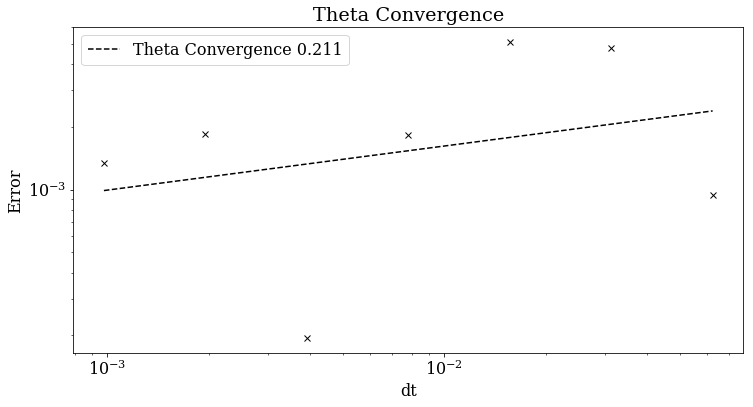

In [10]:
weak_fit = np.polyfit(np.log(dT), np.log(weak_errors), 1)

plt.loglog(dT, weak_errors, 'kx')
plt.loglog(dT, np.exp(weak_fit[1]) * dT ** weak_fit[0],
           'k--', label='Theta Convergence {:2.3f}'.format(weak_fit[0]))
plt.xlabel('dt')
plt.ylabel('Error')
plt.legend()
plt.title('Theta Convergence')
plt.show()

For the theta method, we should should exepct there to be no weak convergence. This is due to the difference in the size of the errors between the deterministic and stochastic parts of the O-U equation. 

For the theta method, the deterministic part of the O-U equation is solved to second order, hence the deterministic error is small in comparison to the stochastic noise, where the error due to the stochastic noise is much larger than. This results in there being little convergence with the expected solution to the O-U equation, as the error is dominated by the random noise of the Weiner increments. As the number of realisations, M, is increased, we would expect the error to decrease as we average over more realised paths. This effectively will cancel out the random noise and the error will then be dominated by the error due to the theta method.

# Theta Histogram

In [7]:
t_start = 0
t_end = 10
N = 1280
M = 10 ** 5
t_end = 10
t, dt = np.linspace(t_start, t_end, N+1, retstep=True)
dW = np.sqrt(dt) * np.random.randn(N, M)

theta = 0.5

X_THETA_H = np.zeros((N+1, M))
for m in range(M):
    X_THETA_H[:, m] = TM(dW[:, m], dt, X0, theta, mu, lamda)

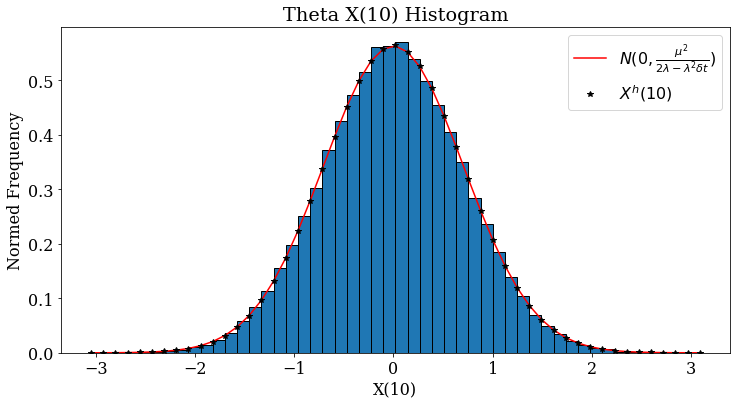

Reference variance: 0.502
Reference mean: 0.000
TM variance: 0.498
TM mean: -0.000


In [40]:
n, bins, patches = plt.hist(X_THETA_H[-1, :], bins=50, edgecolor='black', linewidth=1.0, 
         normed=True)

# construct the norm dist for the reference norm
ref_variance = mu ** 2/(2 * lamda - lamda ** 2 * dt)
ref_sigma = np.sqrt(ref_variance)
ref_mean = 0
ref_norm = norm.pdf(bins, loc=ref_mean, scale=ref_sigma)
plt.plot(bins, ref_norm, 'r-', 
         label=r'$N(0, \frac{\mu^2}{2\lambda - \lambda^2 \delta t})$')

# calculate the norm distribution for theta
TM_var = np.mean(X_THETA_H[-1, :] ** 2)
TM_sigma = np.sqrt(TM_var)
TM_mean = np.mean(X_THETA_H[-1, :])
TM_norm = norm.pdf(bins, loc=EM_mean, scale=EM_sigma)
plt.plot(bins, TM_norm, 'k*', label=r'$X^h(10)$')

plt.xlabel('X(10)')
plt.ylabel('Normed Frequency')
plt.title('Theta X(10) Histogram')
plt.legend()
plt.show()

print('Reference variance: {:2.3f}\nReference mean: {:2.3f}'.format(ref_variance, ref_mean))
print('TM variance: {:2.3f}\nTM mean: {:2.3f}'.format(TM_var, TM_mean))

Here again we see a normal distribution for the value of X(10). This implies that the theta method is working as intended (even though there is no weak convergence) by sampling randomly from a normal distribution.

Again the Theta method is showing that X at late time is following the expected value; a normal distribution. This again implies that the theta method is sampling correctly from a normal distribution and producing correct results, even when there is no weak convergence. 

# Appendix - Computed Solutions

In [14]:
t_start = 0
t_end = 1
N = 2 ** 10
M = 10 ** 3
t, dt = np.linspace(t_start, t_end, N+1, retstep=True)
expected = np.exp(-lamda * t) * X0

n_sols = 5
X_EM = np.zeros((n_sols, len(t), M))
X_TH = np.zeros((n_sols, len(t), M))
for sol in range(n_sols):
    dW = np.sqrt(dt) * np.random.randn(N, M)
    for m in range(M):
        X_EM[sol, :, m] = EM(dW[:, m], dt, X0, fn, gn)
        X_TH[sol, :, m] = TM(dW[:, m], dt, X0, 0.5, mu, lamda)

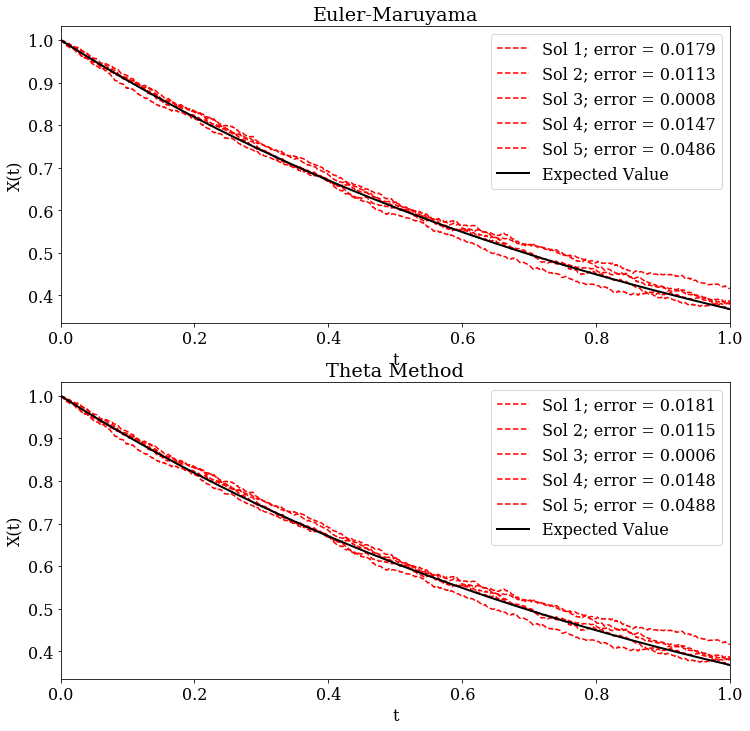

In [15]:
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for i in range(n_sols):
    EM = np.mean(X_EM[i, :, :], axis=1)
    EM_error = np.abs(EM[-1] - expected[-1])
    TH = np.mean(X_TH[i, :, :], axis=1)
    TH_error = np.abs(TH[-1] - expected[-1])
    
    ax1.plot(t, EM, 'r--', label='Sol {}; error = {:1.4f}'.format(i+1, EM_error)) 
    ax2.plot(t, TH, 'r--', label='Sol {}; error = {:1.4f}'.format(i+1, TH_error))

ax1.plot(t, expected, 'k', linewidth=2, label='Expected Value')
ax1.set_title('Euler-Maruyama')
ax1.set_xlabel('t')
ax1.set_ylabel('X(t)')
ax1.legend()
ax1.set_xlim(0, 1)

ax2.plot(t, expected, 'k', linewidth=2, label='Expected Value')
ax2.set_title('Theta Method')
ax2.set_xlabel('t')
ax2.set_ylabel('X(t)')
ax2.set_xlim(0, 1)
ax2.legend()
plt.show()

By looking at the error of the deterministic part (the expected value), we can see that the Theta method is slightly more accurate (but this changes from run to run) than the Euler-Maruyama method. However, with the current parameters, both solutions are very noisy. Increasing the number of realisiations would help to eliminate this noise, and we would expect the Theta method to be more accurate.